In [1]:
import scipy.io
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import describe
import datetime
from datetime import timedelta as timedelta
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy import signal
import os, sys
sys.path.append( '/home/ugrads/c/clearloveyanzhen/CufflessBP/bioz_processing' )
import sicong_util as su
import sicong_duck_path as sp
import sicong_duck_path as sdp
plt.rcParams.update({'font.size': 13})
import seaborn as sns
import scipy as sp # for signal processing
from scipy import signal
from scipy.spatial import distance
import IPython.display as ipd
import random
import math
import mat73

In [ ]:
bmat = su.dir_check(pname='A', file_type='bioz_mat')
fmat = su.dir_check(pname='A', file_type='fprs_mat')

In [17]:
finapres_dict, total_finapres = su.export_finapres_to_dict()
bioz_mat_dict, total_bioz_mat = su.export_bioz_mat_to_dict()
index_used = 10
mat_obj = mat73.loadmat(bioz_mat_dict['A']['01']['11_29_43'][0], use_attrdict=True)['XL_Board']
fprs_obj = pd.read_csv(finapres_dict['A']['01']['11_29_43'][0])

In [4]:
print(fprs_obj['reSYS'].to_numpy().shape)
print(fprs_obj['reDIA'].to_numpy().shape)
print(fprs_obj['time (synced to ppg)'].to_numpy().shape)
fprs_obj

(320,)
(320,)
(320,)


,reSYS,fiSYS,reDIA,fiDIA,time (synced to ppg)
0,115.859985,107.482910,74.096680,56.396484,0.502095
1,118.743896,111.007690,73.196411,55.648804,1.341995
2,122.634888,114.501953,74.996948,57.357788,2.176995
3,123.718262,115.951538,74.432373,56.488037,3.046895
4,122.985840,115.509033,73.867798,56.152344,3.936795
...,...,...,...,...,...
315,141.006470,137.664795,90.438843,70.175171,241.176995
316,138.656616,134.292603,89.981079,69.671631,241.931895
317,140.686035,137.817383,88.256836,68.054199,242.716795
318,145.599365,142.501831,89.828491,69.839478,243.536795


In [18]:
ms_t=mat_obj['all']['ms_t']

(0.0, 1.5)

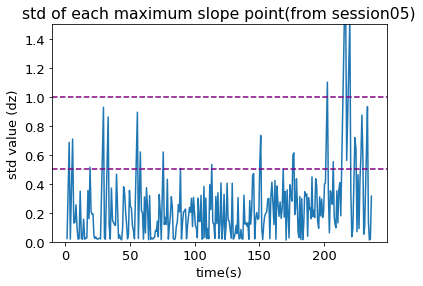

In [6]:
i, j = ms_t.shape
stds = np.array([])
for i in range(i):
    stds=np.append(stds, np.std(ms_t[i]))
plt.plot(ms_t[:,-1], stds)
plt.title('std of each maximum slope point(from session05)')
plt.xlabel('time(s)')
plt.ylabel('std value (dz)')
plt.axhline(y=0.5,color='purple', ls='--')
plt.axhline(y=1,color='purple', ls='--')
plt.ylim([0,1.5])

In [7]:
bmat[index_used]

'/home/data/datasets/sicong_bioz_bp//75-1_75A/session03_0312_2021/test00-20210312 13_34_28.mat'

In [54]:
def make_sample(ppg_ms_t, mat_obj, fprs_obj, len_beats=1, include_labels=1):
    sample_res = 300
    ms_t_array = mat_obj['all']['ms_t'][:,-1]
    ed_idx = np.where(ms_t_array == ppg_ms_t)[0][0]
    st_idx = max(ed_idx - len_beats, 0)
    st_t = ms_t_array[st_idx]
    ed_t = ms_t_array[ed_idx]
    st_i = np.where(mat_obj['bioz'][0]['t_dr']==st_t)[0][0]
    ed_i = np.where(mat_obj['bioz'][0]['t_dr']==ed_t)[0][0]    
    
    # extracting biozs then downsample then concatenate them
    bioz1 = signal.resample(mat_obj['bioz'][0]['dz'][st_i:ed_i+1], len_beats*sample_res)
    bioz2 = signal.resample(mat_obj['bioz'][1]['dz'][st_i:ed_i+1], len_beats*sample_res)
    # bioz3 = signal.resample(mat_obj['bioz'][2]['dz'][st_i:ed_i+1], len_beats*sample_res)
    # bioz4 = signal.resample(mat_obj['bioz'][3]['dz'][st_i:ed_i+1], len_beats*sample_res)
    # out_x = np.concatenate((bioz1, bioz2, bioz3, bioz4), axis=0)
    out_x = np.concatenate((bioz1, bioz2), axis=0)
    
    # processing finapres values     
    fprs_sys = fprs_obj['reSYS'].to_numpy()
    fprs_dia = fprs_obj['reDIA'].to_numpy()
    fprs_time = fprs_obj['time (synced to ppg)'].to_numpy()
    fprs_idx = np.where(fprs_time == fprs_time[(fprs_time<=ppg_ms_t)][-1])[0][0]
    out_y = [fprs_sys[fprs_idx], fprs_dia[fprs_idx]]
    # print(fprs_sys[fprs_idx])
    if include_labels == 1:
        out_x = np.concatenate((out_x,fprs_sys[fprs_idx-len_beats:fprs_idx]), axis=0)
    # print(fprs_sys[fprs_idx-len_beats:fprs_idx])
    return out_x, out_y    
# out_x, out_y = make_sample(val, mat_obj, fprs_obj, len_beats=1)

In [40]:
out_x.shape

(1803,)

In [ ]:
X = []
y = []
len_beats = 3
for subject in ['A']:
    for session in finapres_dict[subject]:
        for trial in finapres_dict[subject][session]:
            for i in range(len(finapres_dict[subject][session][trial])):
                mat_obj = mat73.loadmat(bioz_mat_dict[subject][session][trial][i], use_attrdict=True)['XL_Board']
                fprs_obj = pd.read_csv(finapres_dict[subject][session][trial][i])
                ms_t=mat_obj['all']['ms_t']
                for val in ms_t[10:-10,-1]:
                    out_x, out_y = make_sample(val, mat_obj, fprs_obj, len_beats=10)
                    X.append(out_x)
                    y.append(out_y)
# ms_t=mat_obj['all']['ms_t']
# for val in ms_t[len_beats:-len_beats, -1]:
#     out_x, out_y = make_sample(val, mat_obj, fprs_obj, len_beats=len_beats)
#     X.append(out_x)
#     y.append(out_y)
# X=np.array(X)
# y=np.array(y)
np.save('X_file', X)
np.save('y_file', y)

In [118]:
X = np.load('X_file.npy')
y = np.load('y_file.npy')
X.shape, y.shape

((16527, 6000), (16527, 2))

In [119]:
filter_arr = ((y<[160, 120])&(y>[110, 60]))[:,0]
X = X[filter_arr]
y = y[filter_arr]

In [120]:
y[:,0].shape

(14926,)

In [121]:
def bin_labels(sbp, bin_list=np.arange(115,165,5)):
    for i in range(len(sbp)):
        for each in bin_list:
            if np.absolute(sbp[i] - each) <= 2.5:
                sbp[i] = each
    return sbp
def bin_label2(X, sbp, bin_list=np.arange(115,165,5)):
    new_X = []
    new_sbp = []
    for i in range(len(sbp)):
        for each in bin_list:
            if np.absolute(sbp[i] - each) <= 0.5:
                new_sbp.append(each)
                new_X.append(X[i])
    return new_X, new_sbp
# sbp = bin_labels(sbp=y[:,0])
X, sbp = bin_label2(X, sbp=y[:,0])

In [126]:
X = np.array(X)
sbp = np.array(sbp)

In [127]:
sbp = y[:,0].reshape(-1,1)
sbp = (sbp - 130) / 5
sbp = sbp.astype(int)
sbp
# dbp = y[:,1].reshape(-1,1)
# sbp = y[:,0]

array([[0],
       [0],
       [0],
       ...,
       [2],
       [1],
       [0]])

In [128]:
mx = MinMaxScaler()
ms = MinMaxScaler()
md = MinMaxScaler()
X = mx.fit_transform(X)
# y=ms.fit_transform(y)
# sbp = ms.fit_transform(sbp)
# dbp = md.fit_transform(dbp)
# y_list = ()
# for each in y[:,0]:
    
from sklearn.utils import resample
# X, sbp = resample(X, sbp)
sbp = sbp.reshape(-1,)
print(X.shape, sbp.shape)

(2830, 6000) (14926,)


In [129]:
X=X[:1000,:]
sbp=sbp[:1000,]
print(X.shape, sbp.shape)

(1000, 6000) (1000,)


In [ ]:
from sklearn import svm
import xgboost
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import f1_score, plot_confusion_matrix, mean_squared_error
from sklearn.linear_model import LogisticRegression, LinearRegression
c_val = 0.1
# X_train, X_test, y_train, y_test = train_test_split(X, sbp, test_size=0.3, random_state=42)
lr = LinearRegression()
# xgb = xgboost.XGBRegressor(objective='reg:logistic', eval_metric='rmse')
xgb = xgboost.XGBClassifier(objective='multi:softprob', eval_metric='auc')
models_used = {'xgb':xgb}
model_names = {'xgb':'XGBoost'}
colors_used = {'xgb': 'blue'}
scores = {}
for model in models_used:
    kf = KFold(n_splits=2, shuffle=False)
    scores[model] = cross_val_score(models_used[model], X, sbp, cv=5, scoring='f1_micro')
    for train_index, test_index in kf.split(X, sbp):
        print('cycle')
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = sbp[train_index], sbp[test_index]
        models_used[model].fit(X_train, y_train)
        y_pred = models_used[model].predict(X_test).reshape(-1,1)
        # y_pred = ms.inverse_transform(y_pred)
        # y_test = ms.inverse_transform(y_test)
        # scores[model].append(mean_squared_error(y_test, y_pred, squared=True))

In [131]:
# X_train, X_test, y_train, y_test = train_test_split(X, y[:,sel], test_size=0.3, random_state=42)
# for model in models_used:
#     models_used[model].fit(X_train, y_train)
#     y_pred = models_used[model].predict(X_test)
#     print(model, mean_squared_error(y_test, y_pred, squared=True))
scores

{'xgb': array([0.23 , 0.225, 0.195, 0.195, 0.21 ])}

In [133]:
np.mean(scores['xgb'])

0.211

Text(0.5, 0, '# of fold (10 fold total)')

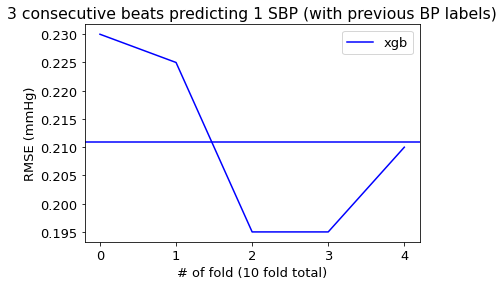

In [134]:
plt.plot(scores['xgb'], color=colors_used['xgb'], label='xgb')
plt.axhline(np.mean(scores['xgb']), color=colors_used[model])
plt.legend()
plt.title('3 consecutive beats predicting 1 SBP (with previous BP labels)')
plt.ylabel('RMSE (mmHg)')
plt.xlabel('# of fold (10 fold total)')

/home/ugrads/c/clearloveyanzhen/miniconda3/envs/torch/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Text(0.5, 1.0, 'Confusion Matrix')

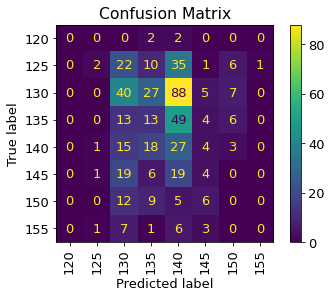

In [139]:
plot_confusion_matrix(models_used['xgb'], X_test, y_test, display_labels=np.arange(120,160,5), xticks_rotation='vertical')
plt.title('Confusion Matrix')

In [138]:
np.arange(115,165,5).shape

(10,)

0.18859454335479459
10.078613182197557


<Figure size 5250x3500 with 0 Axes>

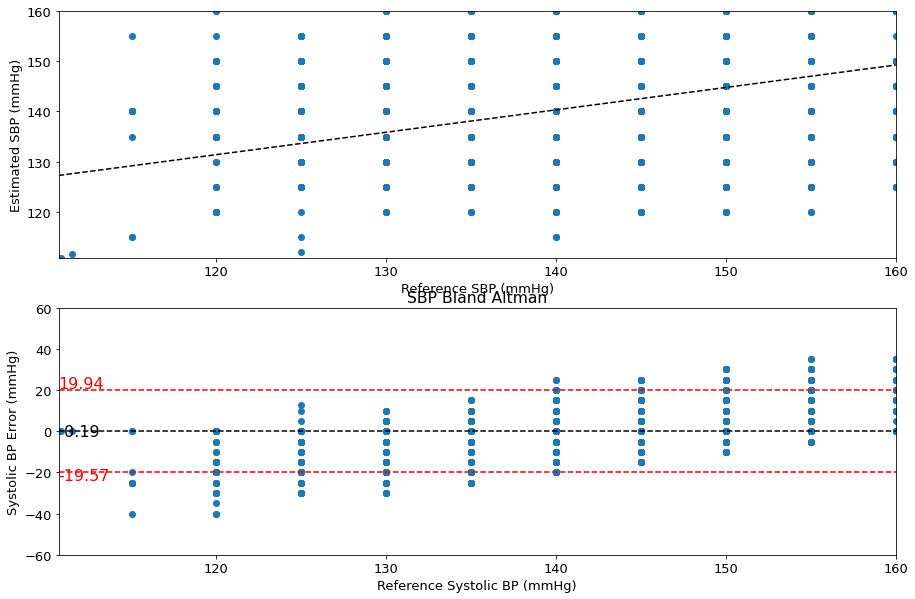

In [15]:
import math
import sklearn
from scipy.stats import pearsonr
from matplotlib.pyplot import figure
figure(figsize=(15, 10), dpi=350)

# rmse = math.sqrt(sklearn.metrics.mean_squared_error(y_test, preds.flatten()))

# print('RMSE... ' + str(rmse))


def bland_altman(y_test, preds, title='plot'):
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 10))

    ######################################################
    ######################## Plot 1 ######################
    ######################################################
    f = ax[0]

    f.set_ylabel('Estimated SBP (mmHg)')
    f.set_xlabel('Reference SBP (mmHg)')

    x = y_test.flatten()
    y = preds.flatten()
    f.scatter(x, y)

    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    #w = [25, 80]
    w = [min(y_test.min(), preds.min()), max(y_test.max(), preds.max())]
    f.plot(w,p(w),"k--")

    f.set_ylim(w)
    f.set_xlim(w)

    ######################################################
    ######################## Plot 2 ######################
    ######################################################
    f = ax[1]

    f.set_ylabel('Systolic BP Error (mmHg)')
    f.set_xlabel('Reference Systolic BP (mmHg)')

    x = y_test.flatten()
    y = y_test.flatten() - preds.flatten()
    f.scatter(x, y)

    bias = y.mean()
    print(bias)
    st = y.std()
    print(st)
    l_loa = bias-1.96*st
    h_loa = bias+1.96*st

    f.axhline(y=bias,  ls='--', color='k')
    f.axhline(y=l_loa, ls='--', color='r')
    f.axhline(y=h_loa, ls='--', color='r')

    f.text(x.min(), h_loa+1, f'{h_loa:.2f}'.rjust(5), color='r', fontsize=16)
    f.text(x.min(),  bias-2.5,   f'{bias:.2f}'.rjust(5), color='k', fontsize=16)
    f.text(x.min(), l_loa-4, f'{l_loa:.2f}'.rjust(5), color='r', fontsize=16)

    f.set_ylim((-60,60))
    f.set_xlim(w)

    f.set_title(title)

    plt.show()
bland_altman(y_test, y_pred, 'SBP Bland Altman')
# bland_altman(new_y_true[:,1], new_y_pred[:,1], 'SBP Bland Altman')
# bland_altman(new_y_true[:,0], new_y_pred[:,0], 'DBP Bland Altman')